In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.insert(0, "../") 
sys.path.insert(1, '../SyMBac/')
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from seaborn import move_legend
import sys
sys.path.insert(0, "../../") 

import scienceplots
import matplotlib

plt.style.use(["science", 'nature'])

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6

from PIL import Image
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import sys
sys.path.insert(0, "../")
from SyMBac.drawing import raster_cell, convert_to_3D
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from skimage.transform import rescale
def bin_data(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])

def bin_data_mid(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])


def bin_data_range(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in ([f"[{int(x.left+1)}, {int(x.right+1)})"  for x in pd.cut(df[column], bins=bins).unique()]) ])

from numba import njit

@njit
def get_CV(arr):
    return arr.std()/arr.mean()


@njit()
def get_intensities(img, mask):
    mask_labels = np.unique(mask)
    mean_intensities = []
    total_intensities = []
    for l, mask_label in enumerate(mask_labels[1:]):
        idxs = np.where(mask == mask_label)
        if len(idxs[0]) > 100:
            pixel_intensities = np.zeros(len(idxs[0]))
            for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                pixel_intensities[k] = img[i,j]
            mean_intensity = np.mean(pixel_intensities)
            total_intensity = np.sum(pixel_intensities)
            mean_intensities.append(mean_intensity)
            total_intensities.append(total_intensity)
    mean_intensities = np.array(mean_intensities)
    total_intensities = np.array(total_intensities)
    return mean_intensities, total_intensities


def get_CV_from_img_mask(img, mask):
    mean_intensities, total_intensities = get_intensities(img,mask)
    return get_CV(mean_intensities), get_CV(total_intensities)

from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


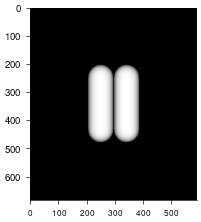

In [3]:
pix_mic_conv = (0.065/1.5)/4

cell_length = 3
cell_width = 1
raster_cell_length = cell_length / pix_mic_conv
raster_cell_width = cell_width / pix_mic_conv

single_cell = (raster_cell(raster_cell_length, raster_cell_width, separation=0))
double_cell = np.concatenate([single_cell,single_cell], axis=1)

single_cell = np.pad(single_cell, (  (250-int(raster_cell_width//2), 250-int(raster_cell_width//2)), (250,250)))

pad_0 = int(single_cell.shape[0] - double_cell.shape[0])//2
pad_1 = int(single_cell.shape[1] - double_cell.shape[1])//2

double_cell = np.pad(double_cell, ((pad_0,pad_0),(pad_1+1,pad_1)))



plt.imshow(double_cell, cmap="Greys_r")

In [4]:
raster_cell_width

92.3076923076923

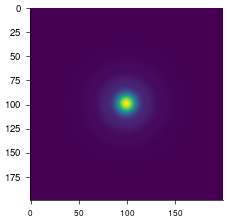

In [5]:
my_kernel = PSF_generator(
    radius = 100, 
    wavelength = 0.515, 
    NA=1.49, 
    n = 1.518, 
    resize_amount=1, 
    pix_mic_conv=pix_mic_conv, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = int(raster_cell_width),
    pz=0.5,
    working_distance = 170
)
my_kernel.calculate_PSF()
psf = my_kernel.kernel.sum(axis=0)
#psf = np.array([layer/layer.sum() for layer in psf])
psf /= psf.sum()
plt.imshow(psf)

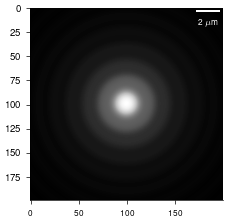

In [9]:
fig, ax = plt.subplots()
ax.imshow(psf**0.5, cmap="Greys_r")
scalebar = ScaleBar(0.08, "um", label_loc=None, scale_loc=None, box_alpha=0, color="white", length_fraction=0.25)
ax.add_artist(scalebar)

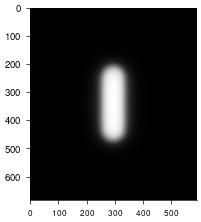

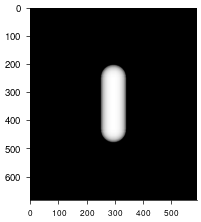

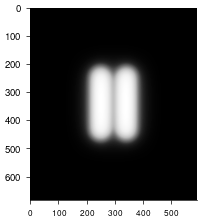

In [10]:
single_cell_3D = convert_to_3D(single_cell)
double_cell_3D = convert_to_3D(double_cell)
single_cell_conv = convolve_rescale(single_cell_3D.astype(np.float32).sum(axis=0), psf, 1, False) 
double_cell_conv = convolve_rescale(double_cell_3D.astype(np.float32).sum(axis=0), psf, 1, False) 
plt.imshow(single_cell_conv, cmap="Greys_r")
plt.show()
plt.imshow(single_cell,cmap="Greys_r")
plt.show()
plt.imshow(double_cell_conv, cmap="Greys_r")
plt.show()

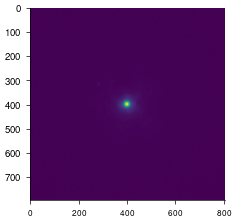

In [11]:
real_PSF = tifffile.imread("../../PSF_comparison/single_100x_PSF_postmag.tif").astype(np.float32)
c = int((real_PSF.shape[-1] - 200)/2)
x_offset = 2
y_offset = 3.5
real_PSF_slice = 44
real_PSF = real_PSF[real_PSF_slice-10:real_PSF_slice+10,2].sum(axis=0) # 0.1micron z step
real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
real_PSF = real_PSF[c-int(np.floor(y_offset)):-c-int(np.ceil(y_offset)),c-int(np.floor(x_offset)):-c+1-int(np.ceil(x_offset))]
real_PSF = rescale(real_PSF, 4  , anti_aliasing=True)
real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
real_PSF /= real_PSF.sum()
plt.imshow(real_PSF)#[350:-350,350:-350])

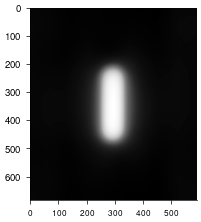

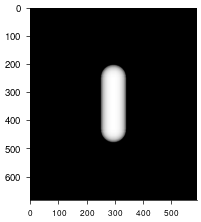

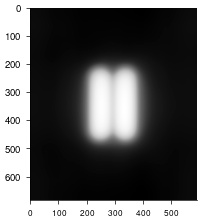

In [12]:
### Real PSF
single_cell_emp_conv = convolve_rescale(single_cell_3D.astype(np.float32).sum(axis=0), real_PSF, 1, False) 
double_cell_emp_conv = convolve_rescale(double_cell_3D.astype(np.float32).sum(axis=0), real_PSF, 1, False) 
plt.imshow(single_cell_emp_conv, cmap="Greys_r")
plt.show()
plt.imshow(single_cell,cmap="Greys_r")
plt.show()
plt.imshow(double_cell_emp_conv, cmap="Greys_r")
plt.show()

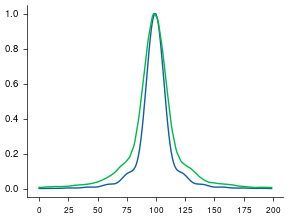

In [13]:
plt.plot(psf[100,:] / psf[100,:].max())
plt.plot(real_PSF[400,300:500] / real_PSF[400,300:500].max())


In [14]:
np.sum(single_cell_conv * (single_cell > 0)) / np.sum(single_cell_conv)

0.81984633

In [15]:
ss_trace = single_cell_conv[single_cell_conv.shape[0]//2,:]
ss_trace_padded = np.pad(ss_trace,(0,int(round(raster_cell_width))))
ss_trace_padded2 = np.pad(ss_trace,(int(round(raster_cell_width)),0))
ds_trace = double_cell_conv[double_cell_conv.shape[0]//2,:]
ds_trace_padded = ds_trace#np.pad(ds_trace, int(round(raster_cell_width)/2))

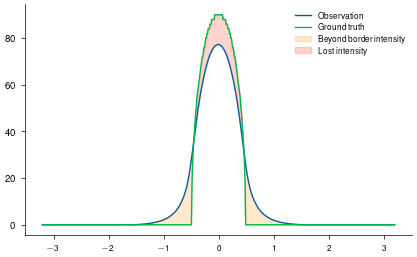

In [16]:
plt.figure(figsize=(5,3))
y1 = ss_trace
y2 = single_cell_3D.sum(axis=0)[360,:]
x = np.arange(-len(ss_trace)/2, len(ss_trace)/2) * pix_mic_conv
plt.plot(x, y1)
plt.plot(x, y2)

plt.fill_between(x, y1, y2, where=(y1>y2), color = "C2", alpha = 0.2)
plt.fill_between(x, y1, y2, where=(y1<y2), color = "C3", alpha = 0.2)
#plt.xlim(-1.5,1.5)
plt.legend(["Observation","Ground truth", "Beyond border intensity", "Lost intensity"])

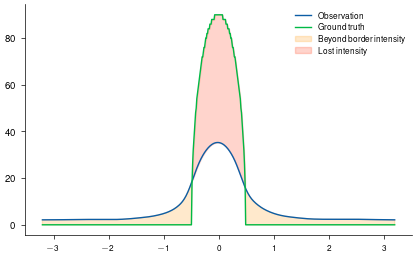

In [17]:
ss_trace_emp_conv = single_cell_emp_conv[single_cell_emp_conv.shape[0]//2,:]
ss_trace_padded_emp_conv = np.pad(ss_trace_emp_conv,(0,int(round(raster_cell_width))))
ss_trace_padded2_emp_conv = np.pad(ss_trace_emp_conv,(int(round(raster_cell_width)),0))
ds_trace_emp_conv = double_cell_emp_conv[double_cell_emp_conv.shape[0]//2,:]
ds_trace_padded_emp_conv = ds_trace_emp_conv#np.pad(ds_trace, int(round(raster_cell_width)/2))

plt.figure(figsize=(5,3))
y1_emp_conv = ss_trace_emp_conv
y2_emp_conv = single_cell_3D.sum(axis=0)[360,:]
x_emp_conv = np.arange(-len(ss_trace_emp_conv)/2, len(ss_trace_emp_conv)/2) * pix_mic_conv
plt.plot(x_emp_conv, y1_emp_conv)
plt.plot(x_emp_conv, y2_emp_conv)

plt.fill_between(x_emp_conv, y1_emp_conv, y2_emp_conv, where=(y1_emp_conv>y2_emp_conv), color = "C2", alpha = 0.2)
plt.fill_between(x_emp_conv, y1_emp_conv, y2_emp_conv, where=(y1_emp_conv<y2_emp_conv), color = "C3", alpha = 0.2)
#plt.xlim(-1.5,1.5)
plt.legend(["Observation","Ground truth", "Beyond border intensity", "Lost intensity"])

In [18]:
np.sum(single_cell_conv * (single_cell > 0)) / np.sum(single_cell_conv)

0.81984633

(-2.7, 2.7)

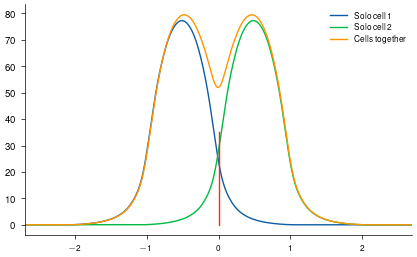

In [19]:
plt.figure(figsize=(5,3))

plt.plot(
    np.arange(-len(ss_trace_padded)/2, len(ss_trace_padded)/2)* pix_mic_conv, ss_trace_padded
)

plt.plot(
    np.arange(-len(ss_trace_padded)/2, len(ss_trace_padded)/2)* pix_mic_conv, ss_trace_padded2
)


plt.plot(
    np.arange(-len(ds_trace_padded)/2, len(ds_trace_padded)/2)* pix_mic_conv, ds_trace_padded
)
plt.plot([0,0],[0,35])
plt.legend(["Solo cell 1", "Solo cell 2", "Cells together"])
plt.xlim(-2.7,2.7)

(-2.7, 2.7)

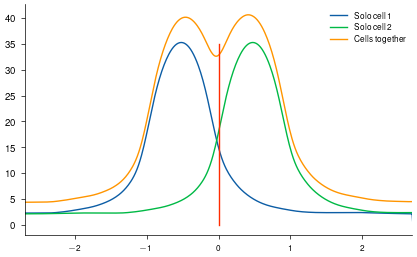

In [20]:
plt.figure(figsize=(5,3))

plt.plot(
    np.arange(-len(ss_trace_padded_emp_conv)/2, len(ss_trace_padded_emp_conv)/2)* pix_mic_conv, ss_trace_padded_emp_conv
)

plt.plot(
    np.arange(-len(ss_trace_padded_emp_conv)/2, len(ss_trace_padded_emp_conv)/2)* pix_mic_conv, ss_trace_padded2_emp_conv
)


plt.plot(
    np.arange(-len(ds_trace_padded_emp_conv)/2, len(ds_trace_padded_emp_conv)/2)* pix_mic_conv, ds_trace_padded_emp_conv
)
plt.plot([0,0],[0,35])
plt.legend(["Solo cell 1", "Solo cell 2", "Cells together"])
plt.xlim(-2.7,2.7)

In [21]:
from skimage.segmentation import find_boundaries

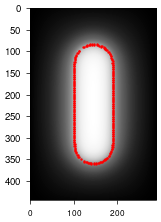

In [22]:
single_cell = single_cell[120:-120:,150:-150]
single_cell_conv = single_cell_conv[120:-120:,150:-150]
boundaries = np.argwhere(find_boundaries(single_cell>0))

fig, ax = plt.subplots()
ax.imshow(single_cell_conv**0.5, cmap="Greys_r")
scalebar = ScaleBar(0.065/1.5, "um",scale_loc=None, label_loc=None, length_fraction=0.15, color="white", box_color="k")
ax.scatter(boundaries[:,1][::5], boundaries[:,0][::5], c = "r", s = 0.5)

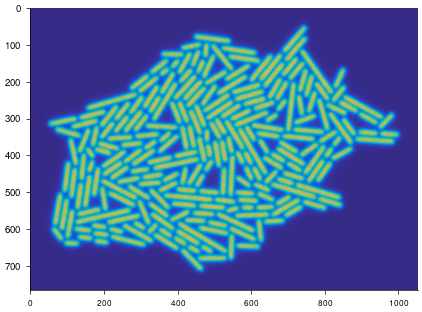

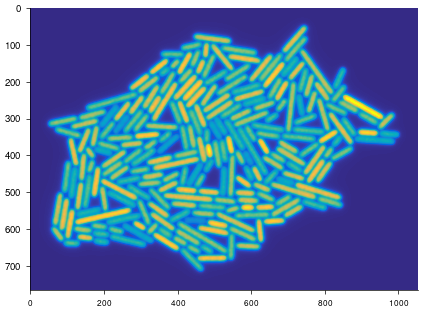

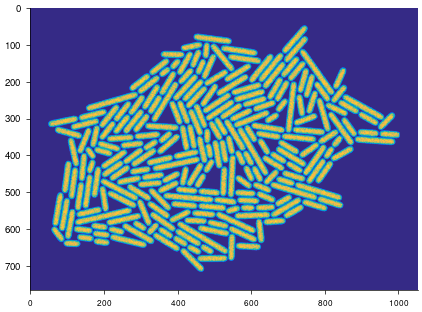

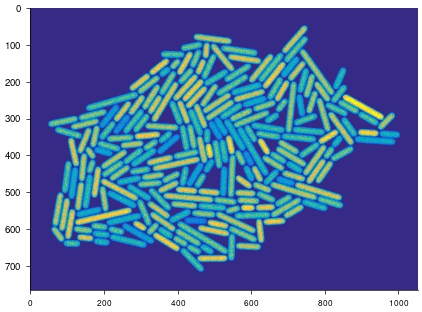

In [23]:
import tifffile

vmin = 0
vmax = 1
colony_ID_low_CV = 315
colony_ID_high_CV = colony_ID_low_CV + 2844

low_CV_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_normal/training_data_100x_0.55_green_1.49_1.518/synth_imgs/{str(colony_ID_low_CV).zfill(4)}.tif")
high_CV_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_normal/training_data_100x_0.55_green_1.49_1.518/synth_imgs/{str(colony_ID_high_CV).zfill(4)}.tif")



plt.figure(figsize=(5,5))
plt.imshow(low_CV_conv, cmap=parula_map, vmin=0,vmax = high_CV_conv.max()*0.9 ) 
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(high_CV_conv, cmap=parula_map, vmin=0,vmax = high_CV_conv.max()*0.9 )
plt.show()



low_CV_unconv = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D//{str(colony_ID_low_CV+1).zfill(5)}.tif").sum(axis=0)
high_CV_unconv = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D//{str(colony_ID_high_CV+1).zfill(5)}.tif").sum(axis=0)

plt.figure(figsize=(5,5))
plt.imshow(gaussian_filter(low_CV_unconv,0), cmap=parula_map, vmin=0, vmax = high_CV_conv.max()*0.9  )
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(gaussian_filter(high_CV_unconv,0), cmap=parula_map, vmin=0, vmax = high_CV_conv.max()*1.1)
plt.show()


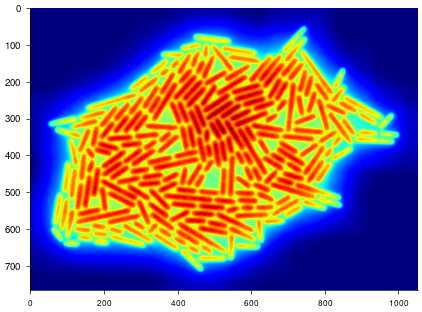

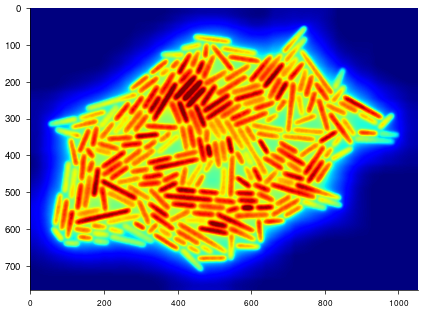

In [24]:

low_CV_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_empirical_PSF/training_data_100x_0.55_green_1.49_1.518//synth_imgs/{str(colony_ID_low_CV).zfill(4)}.tif")
high_CV_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_empirical_PSF/training_data_100x_0.55_green_1.49_1.518/synth_imgs/{str(colony_ID_high_CV).zfill(4)}.tif")

plt.figure(figsize=(5,5))
plt.imshow(low_CV_conv, cmap="jet", vmin=0,vmax = high_CV_conv.max()*0.9 ) 
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(high_CV_conv, cmap="jet", vmin=0,vmax = high_CV_conv.max()*0.9 )
plt.show()


In [25]:
mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_low_CV+1).zfill(5)}.png"))

get_CV_from_img_mask(low_CV_conv, mask)[0]

mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_low_CV+1).zfill(5)}.png"))

get_CV_from_img_mask(low_CV_unconv, mask)[0]

mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_low_CV+1).zfill(5)}.png"))

get_CV_from_img_mask(high_CV_conv, mask)[0]

mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_low_CV+1).zfill(5)}.png"))

get_CV_from_img_mask(high_CV_unconv, mask)[0]

0.22329372666480488

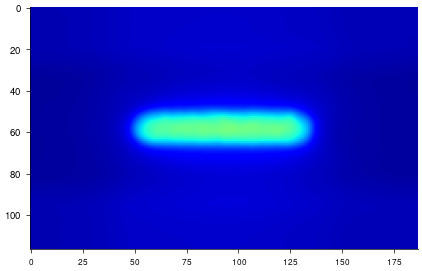

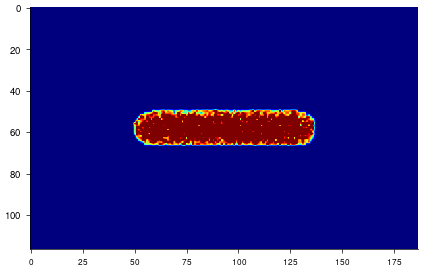

In [26]:


single_cell_colony_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_empirical_PSF/training_data_100x_0.55_green_1.49_1.518//synth_imgs/{str(colony_ID_low_CV-30).zfill(4)}.tif")
single_cell_colony_unconv = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D/{str(colony_ID_low_CV-29).zfill(5)}.tif").sum(axis=0)

plt.figure(figsize=(5,5))
plt.imshow(single_cell_colony_conv, cmap="jet", vmin=0,vmax = low_CV_conv.max()*0.9 )
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(single_cell_colony_unconv, cmap="jet", vmin=0,vmax = low_CV_conv.max()*0.9 ) 
plt.show()

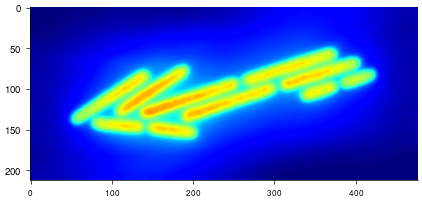

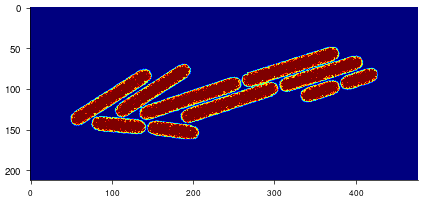

In [27]:


ten_cell_colony_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_empirical_PSF/training_data_100x_0.55_green_1.49_1.518//synth_imgs/{str(colony_ID_low_CV-17).zfill(4)}.tif")
ten_cell_colony_unconv = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D/{str(colony_ID_low_CV-16).zfill(5)}.tif").sum(axis=0)

plt.figure(figsize=(5,5))
plt.imshow(ten_cell_colony_conv, cmap="jet", vmin=0,vmax = low_CV_conv.max()*0.9 ) 
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(ten_cell_colony_unconv, cmap="jet", vmin=0,vmax = low_CV_conv.max()*0.9 ) 
plt.show()

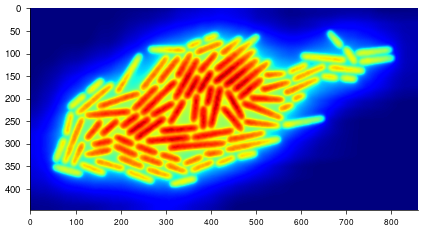

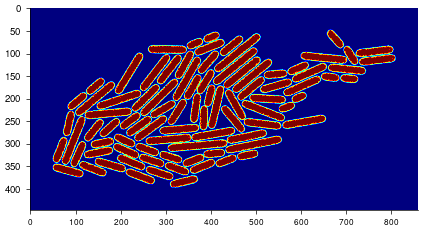

In [28]:


hundred_cell_colony_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_empirical_PSF/training_data_100x_0.55_green_1.49_1.518//synth_imgs/{str(colony_ID_low_CV-6).zfill(4)}.tif")
hundred_cell_colony_unconv = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D/{str(colony_ID_low_CV-5).zfill(5)}.tif").sum(axis=0)

plt.figure(figsize=(5,5))
plt.imshow(hundred_cell_colony_conv, cmap="jet", vmin=0,vmax = high_CV_conv.max()*0.9 ) 
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(hundred_cell_colony_unconv, cmap="jet", vmin=0,vmax = high_CV_conv.max()*0.9 ) 
plt.show()

In [29]:
colony_plot_data = pd.read_pickle("../../microcolony_analysis/microcolony_plotting_data.pickle")

No handles with labels found to put in legend.


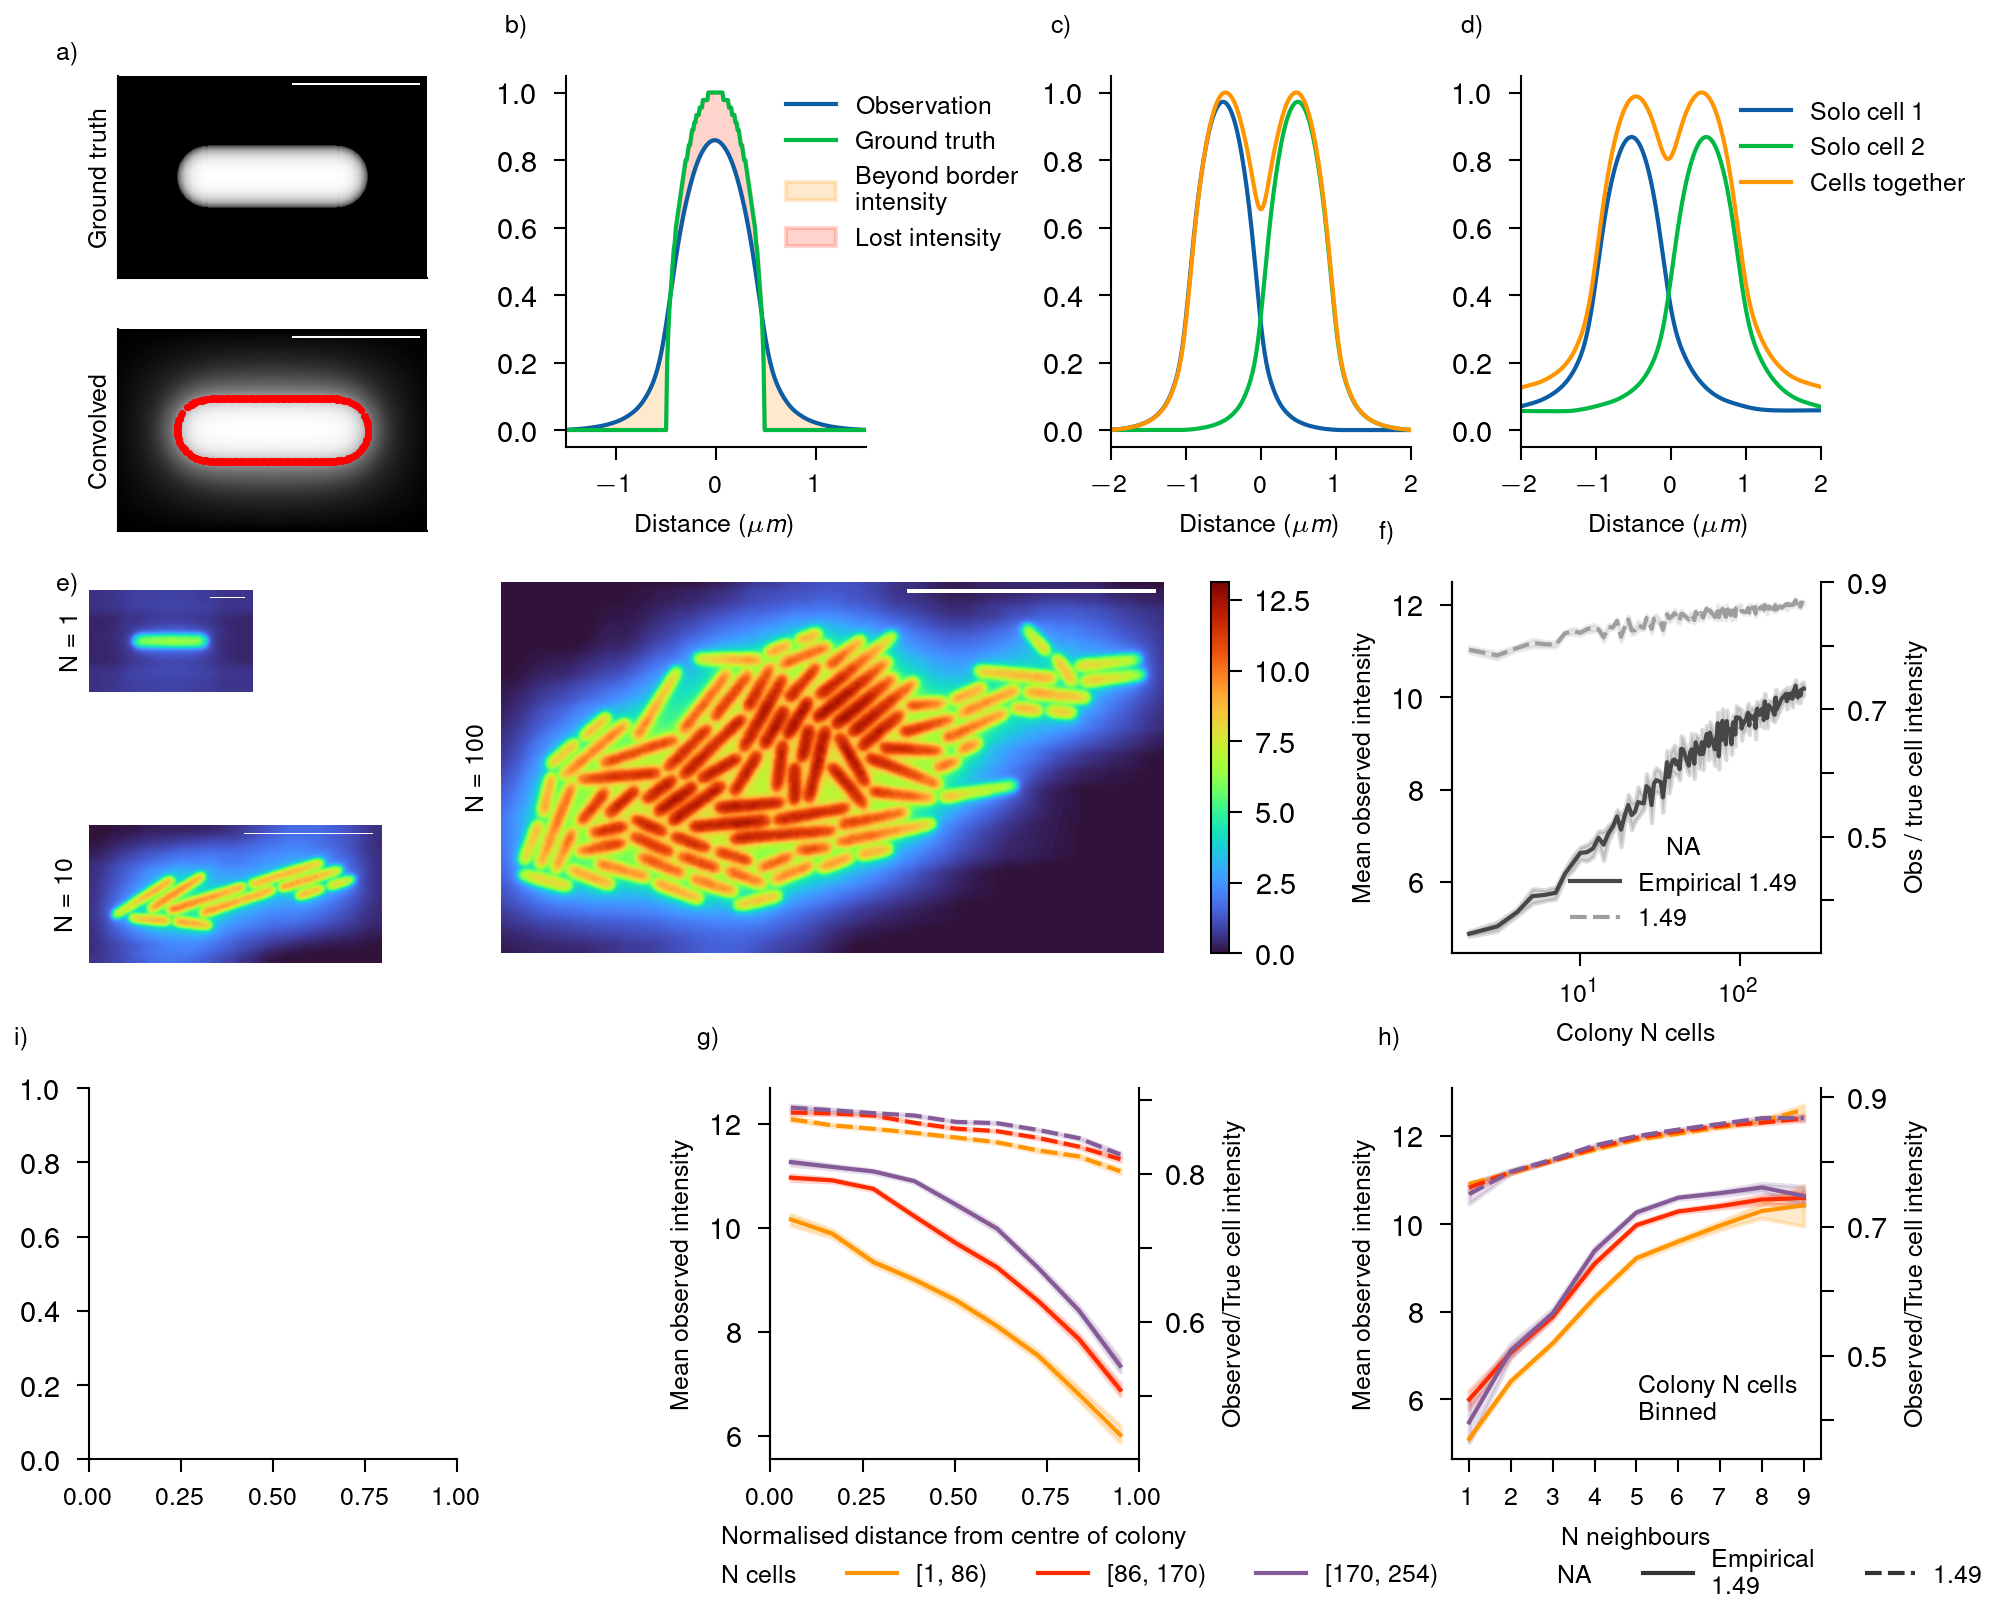

In [30]:
################### Main figure #################

cm = 1/2.54
fig, axs = plt.subplots(figsize = (21.9*cm,18*cm), dpi = 300)
a = matplotlib.cm.get_cmap('Set2')
plt.subplots_adjust(hspace=1.5)
plt.subplots_adjust(wspace=1.5)

############## Single cell unconv and conv ##############

UNCONV_CELL = plt.subplot2grid((20, 30), (0, 0), colspan=6, rowspan=3)
plt.text(-.2, 1.165, 'a)', ha='left', va='top', transform=UNCONV_CELL.transAxes)
plt.text(-.1, 0.5, 'Ground truth', ha='left', va='center', rotation="vertical", transform=UNCONV_CELL.transAxes)


plt.imshow(np.rot90(single_cell),cmap="Greys_r")
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) ## 2 micron
UNCONV_CELL.add_artist(scalebar)

CONV_CELL = plt.subplot2grid((20, 30), (3, 0), colspan=6, rowspan=3)
plt.imshow(np.rot90(single_cell_conv**0.5), cmap="Greys_r")
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None, scale_loc="none", box_alpha=0, color="white", length_fraction=0.5) ## 2 micron
CONV_CELL.add_artist(scalebar)
plt.scatter(boundaries[:,0][::5], boundaries[:,1][::5], c = "r", s = 0.5)
for ax in [UNCONV_CELL, CONV_CELL]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.text(-.1, 0.5, 'Convolved', ha='left', va='center', rotation="vertical", transform=CONV_CELL.transAxes)

############ Single cell trace #####################

SS_TRACE = plt.subplot2grid((20, 30), (0, 7), colspan=5, rowspan=5)
plt.text(-.2, 1.165, 'b)', ha='left', va='top', transform=SS_TRACE.transAxes)

y1 = y1/y2.max()
y2 = y2/y2.max()

plt.plot(x, y1)
plt.plot(x, y2)

plt.fill_between(x, y1, y2, where=(y1>y2), color = "C2", alpha = 0.2)
plt.fill_between(x, y1, y2, where=(y1<y2), color = "C3", alpha = 0.2)
#plt.xlim(-1.5,1.5)
plt.xlim(-1.5,1.5)
plt.xlabel("Distance ($\mu m$)")
plt.legend(["Observation", "Ground truth", "Beyond border\nintensity", "Lost intensity"])
move_legend(SS_TRACE, (0.7,0.5))
############ Double cell trace #####################

DS_TRACE = plt.subplot2grid((20, 30), (0, 15), colspan=5, rowspan=5)
plt.text(-.2, 1.165, 'c)', ha='left', va='top', transform=DS_TRACE.transAxes)

plt.plot(
    np.arange(-len(ss_trace_padded)/2, len(ss_trace_padded)/2)* pix_mic_conv, ss_trace_padded/ds_trace_padded.max()
)

plt.plot(
    np.arange(-len(ss_trace_padded)/2, len(ss_trace_padded)/2)* pix_mic_conv, ss_trace_padded2/ds_trace_padded.max()
)


plt.plot(
    np.arange(-len(ds_trace_padded)/2, len(ds_trace_padded)/2)* pix_mic_conv, ds_trace_padded/ds_trace_padded.max()
)
plt.xlim(-2,2)
plt.xlabel("Distance ($\mu m$)")

############ Double cell trace emp conv #####################


DS_TRACE_EMP_CONV = plt.subplot2grid((20, 30), (0, 21), colspan=5, rowspan=5)
plt.text(-.2, 1.165, 'd)', ha='left', va='top', transform=DS_TRACE_EMP_CONV.transAxes)

plt.plot(
    np.arange(-len(ss_trace_padded_emp_conv)/2, len(ss_trace_padded_emp_conv)/2)* pix_mic_conv, ss_trace_padded_emp_conv/ds_trace_padded_emp_conv.max()
)

plt.plot(
    np.arange(-len(ss_trace_padded_emp_conv)/2, len(ss_trace_padded_emp_conv)/2)* pix_mic_conv, ss_trace_padded2_emp_conv/ds_trace_padded_emp_conv.max()
)


plt.plot(
    np.arange(-len(ds_trace_padded_emp_conv)/2, len(ds_trace_padded_emp_conv)/2)* pix_mic_conv, ds_trace_padded_emp_conv/ds_trace_padded_emp_conv.max()
)
plt.xlabel("Distance ($\mu m$)")
plt.xlim(-2,2)

plt.legend(["Solo cell 1", "Solo cell 2", "Cells together"])
move_legend(DS_TRACE_EMP_CONV, (0.7,0.65))


################ Conv grid ##################################

SINGLE_CELL_CONV = plt.subplot2grid((20, 30), (6, 0), colspan=3, rowspan=2)
plt.text(-.2, 1.165, 'e)', ha='left', va='top', transform=SINGLE_CELL_CONV.transAxes)
plt.text(-.178, 0.5, 'N = 1', ha='left', va='center', rotation="vertical", transform=SINGLE_CELL_CONV.transAxes)

plt.imshow(single_cell_colony_conv, cmap="turbo", vmin=0,vmax = low_CV_conv.max()*0.9 ) 
plt.yticks([])
plt.xticks([])

scalebar = ScaleBar(0.05, "um", label_loc=None, scale_loc =  "none", box_alpha=0, color="white", length_fraction=0.5) # 2 micron
SINGLE_CELL_CONV.add_artist(scalebar)

TEN_CELL_CONV = plt.subplot2grid((20, 120), (8, 0), colspan=18, rowspan=4)
plt.text(-.04, 0.5, 'N = 10', ha='right', va='center', rotation="vertical", transform=TEN_CELL_CONV.transAxes)

plt.imshow(ten_cell_colony_conv[:,15:-10], cmap="turbo", vmin=0,vmax = low_CV_conv.max()*0.9 ) 
plt.yticks([])
plt.xticks([])

scalebar = ScaleBar(0.05, "um", label_loc=None,  scale_loc =  "none", box_alpha=0, color="white", length_fraction=0.5) # 10 micron 
TEN_CELL_CONV.add_artist(scalebar)

HUNDRED_CELL_CONV = plt.subplot2grid((20, 90), (6, 14), colspan=43, rowspan=5)
_ = plt.imshow(hundred_cell_colony_conv[:,30:-30], cmap="turbo", vmin=0,vmax = high_CV_conv.max()*0.9 ) 
fig.colorbar(_, ax=HUNDRED_CELL_CONV)
plt.yticks([])
plt.xticks([])
plt.text(-.02, 0.5, 'N = 100', ha='right', va='center', rotation="vertical", transform=HUNDRED_CELL_CONV.transAxes)

scalebar = ScaleBar(0.05, "um", label_loc=None,  scale_loc =  "none", box_alpha=0, color="white", length_fraction=0.5) # 15 micron
HUNDRED_CELL_CONV.add_artist(scalebar)

for ax in [SINGLE_CELL_CONV, TEN_CELL_CONV, HUNDRED_CELL_CONV]:
    ax.spines[['left', 'bottom']].set_visible(False)

################# Mean observed intensity vs colony N cells #################

INTENSITY_VS_N_CELLS = plt.subplot2grid((20, 30), (6, 20), colspan=6, rowspan=5)
plt.text(-.2, 1.165, 'f)', ha='left', va='top', transform=INTENSITY_VS_N_CELLS.transAxes)


sns.lineplot(
    data = colony_plot_data.query("`True CV` < 0.05 & `NA` != 0.95"),
    x = "Colony N cells",
    y = "Mean observed intensity",
    hue = "NA",
    style = "NA", 
    errorbar=('ci', 99), palette=["C5", "C6"]
)
plt.xscale("log")
ax2 = plt.twinx()
g = sns.lineplot(
    data = colony_plot_data.query("`True CV` < 0.05 & `NA` != 0.95"),
    x = "Colony N cells",
    y = "Observed cell intensity / True cell intensity (mean)",
    hue = "NA", alpha=0, legend = False, errorbar=None)
ax2.set_ylabel("Obs / true cell intensity")
for ind, label in enumerate(ax2.get_yticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
INTENSITY_VS_N_CELLS.spines[['right']].set_visible(True)
################# Normalised distance to centre of colony ###################

DISTANCE_CELLS = plt.subplot2grid((20, 30), (12, 10), colspan=6, rowspan=5)
plt.text(-.2, 1.165, 'g)', ha='left', va='top', transform=DISTANCE_CELLS.transAxes)

sns.lineplot(
    data = colony_plot_data.query("`Colony N cells` > 20 & `True CV` < 0.05 & `NA` != 0.95 & `Normalised distance from centre of colony` <= 1"),
    x = "Normalised distance from centre of colony (binned)",
    y = "Mean observed intensity",
    hue = "Colony N cells (binned)",
    errorbar=('ci', 99), 
    style="NA", legend = None, palette=["C2", "C3", "C4"]
)
plt.xlabel("Normalised distance from centre of colony")
ax2 = plt.twinx()
sns.lineplot(
    data = colony_plot_data.query("`Colony N cells` > 20 & `True CV` < 0.05 & `NA` != 0.95 & `Normalised distance from centre of colony` <= 1"),
    x = "Normalised distance from centre of colony (binned)",
    y = "Observed cell intensity / True cell intensity (mean)",
    hue = "Colony N cells (binned)",
    style="NA", legend=None, alpha=0, errorbar=None
)
plt.ylabel("Observed/True cell intensity")
for ind, label in enumerate(ax2.get_yticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
DISTANCE_CELLS.spines[['right']].set_visible(True)
plt.xlim(0,1)
################# Normalised distance to centre of colony ###################

INTENSITY_VS_N_NEIGHBOURS =  plt.subplot2grid((20, 30), (12, 20), colspan=6, rowspan=5)
plt.text(-.2, 1.165, 'h)', ha='left', va='top', transform=INTENSITY_VS_N_NEIGHBOURS.transAxes)

sns.lineplot(
    data = colony_plot_data.query("`Colony N cells` > 0 & `True CV` < 0.05 & `NA` != 0.95"),
    x = "N neighbours",
    y = "Mean observed intensity",
    hue = "Colony N cells (binned)",
    errorbar=('ci', 99), 
    style="NA", palette=["C2", "C3", "C4"]
)

ax2 = plt.twinx()
sns.lineplot(
    data = colony_plot_data.query("`Colony N cells` > 0 & `True CV` < 0.05 & `NA` != 0.95"),
    x = "N neighbours",
    y = "Observed cell intensity / True cell intensity (mean)",
    hue = "Colony N cells (binned)",
    style="NA", legend=None, alpha=0, errorbar=None
)
plt.ylabel("Observed/True cell intensity")
for ind, label in enumerate(ax2.get_yticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
INTENSITY_VS_N_NEIGHBOURS.spines[['right']].set_visible(True)
INTENSITY_VS_N_NEIGHBOURS.xaxis.set_major_locator(MaxNLocator(integer=True))
move_legend(INTENSITY_VS_N_NEIGHBOURS, (-2.2,-.4), ncol=8)
INTENSITY_VS_N_NEIGHBOURS.legend_.texts[0].set_text("N cells")
INTENSITY_VS_N_NEIGHBOURS.legend_.texts[5].set_text("Empirical\n1.49")

plt.legend(title="Colony N cells\nBinned")


################# CV plot ##################################

CV_PLOT = plt.subplot2grid((20, 30), (12, 0), colspan=6, rowspan=5)
plt.text(-.2, 1.165, 'i)', ha='left', va='top', transform=CV_PLOT.transAxes)

#g = sns.scatterplot(
#    data=colony_plot_data.drop_duplicates(["Colony ID", "NA","Wavelength"]).query("`Wavelength` == 0.55 & NA != 0.95 & `Colony N cells` > 50 "), 
#    x="True CV", 
#    y = "Observed CV", 
#    alpha=0.6, palette="icefire", hue = "NA"
#)



#g.axes.plot([0,0.3],[0,0.3], c="k")


plt.savefig("figure_4.svg")




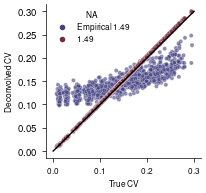

In [35]:
plt.figure(figsize=(2,2))
g = sns.scatterplot(
    data=colony_plot_data.drop_duplicates(["Colony ID", "NA","Wavelength"]).query("`Wavelength` == 0.55 & NA != 0.95 & `Colony N cells` > 50 "), 
    x="True CV", 
    y = "Deconvolved CV", 
    alpha=0.6, palette="icefire", hue = "NA"
)
g.axes.plot([0,0.3],[0,0.3], c="k")
plt.savefig("../../SI_assets/deconvolved.png",dpi=300)